In [1]:
import os
import json
import wandb
import subprocess
import random
from tqdm import tqdm
from PIL import Image
import torch
import numpy as np
import io
from openai import OpenAI
import base64
from pydantic import BaseModel

# %%
import torch
from sd_pipeline import StableDiffusion3Pipeline
from diffusers import StableDiffusion3Pipeline as StableDiffusion3PipelineVanilla

from sd_processor import JointAttnProcessor2_0
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]


Using seed: 1748163566


100%|██████████| 16/16 [00:05<00:00,  3.06it/s]


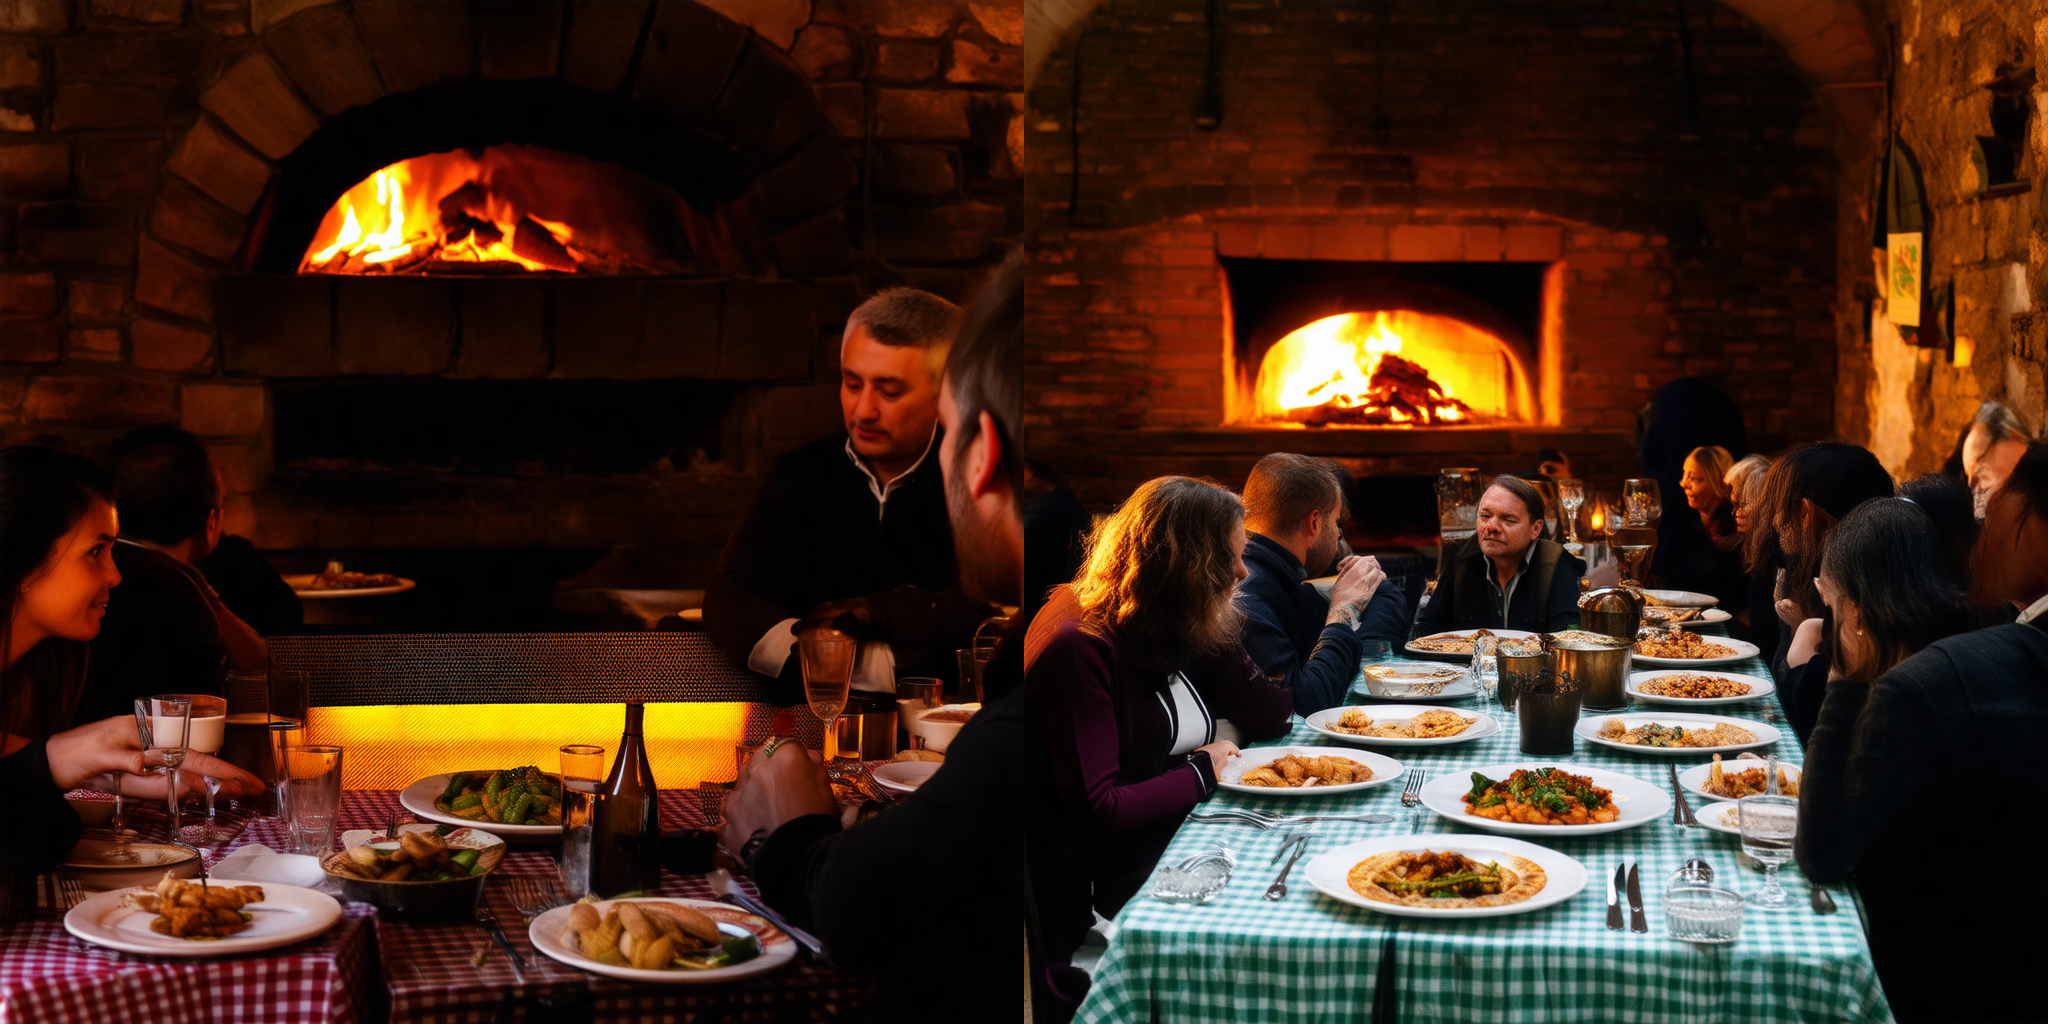

In [129]:
positive_prompt = "A bustling Italian pizzeria with diners gathered around tables topped with plates of various food, glasses, and cutlery. The wood-fired oven glows in the background as people share meals and conversation in a warmly lit, authentic atmosphere, checkered tablecloths and rustic decor throughout."
negative_prompt = "pizza"
# positive_prompt = "A quiet reading room with rows of wooden shelves, cozy armchairs and large windows letting in soft daylight, evoking a tranquil and studious atmosphere for visitors."
# negative_prompt = "book"
import time
seed = int(time.time())
print(f"Using seed: {seed}")    

for block in pipe.transformer.transformer_blocks:
    block.attn.processor.neg_prompt_len=max([
        len(pipe.tokenizer.tokenize(negative_prompt)), 
        len(pipe.tokenizer_2.tokenize(negative_prompt)),
        len(pipe.tokenizer_3.tokenize(negative_prompt))
    ]) + 1 


image_ours = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    avoidance_factor=7, 
    guidance_scale=7, 
    negative_offset=-15, #-8
    clamp_value=20, 
    generator=torch.manual_seed(seed),  
).images

negative_guidance_scales = pipe.negative_guidance_scales
weight_maps = pipe.weight_maps
image_vanilla = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    guidance_scale=7, 
    vanilla=True,
    generator=torch.manual_seed(seed),
).images

Image.fromarray(
            np.concatenate(
                [np.array(image_ours[-1]), np.array(image_vanilla[-1])], axis=1
            ) 
 ) 

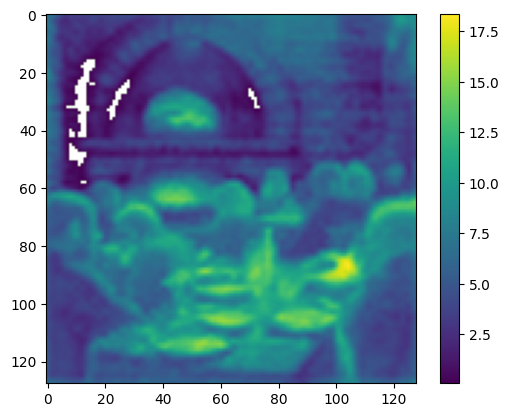

In [118]:
import pylab
pylab.imshow(weight_maps[10].mean(0).mean(0).cpu().float().numpy())
pylab.colorbar()

In [126]:
import requests
from PIL import Image
import torch
from PIL import ImageDraw

from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-large-patch14-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-large-patch14-ensemble").to("cuda")

texts = [["pizza", "A bustling Italian pizzeria with diners gathered around tables topped with plates of various food"]]
for image in [image_ours[-1], image_vanilla[-1]]:
  inputs = processor(text=texts, images=image, return_tensors="pt", truncation=True).to("cuda")

  with torch.no_grad():
    outputs = model(**inputs) 

  target_sizes = torch.Tensor([image.size[::-1]])
  results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
  i = 0
  text = texts[i]
  boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
  try:
    max_score_term0 = torch.max(scores[labels == 0])
  except RuntimeError:
    max_score_term0 = 0
    
  try:
    max_score_term1 = torch.max(scores[labels == 1])
  except RuntimeError:
    max_score_term1 = 0
  print(max_score_term0, max_score_term1, max_score_term1 - max_score_term0)

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/transformers/models/owlv2/processing_owlv2.py:213: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


0 tensor(0.3175, device='cuda:0') tensor(0.3175, device='cuda:0')
tensor(0.3292, device='cuda:0') tensor(0.3762, device='cuda:0') tensor(0.0471, device='cuda:0')


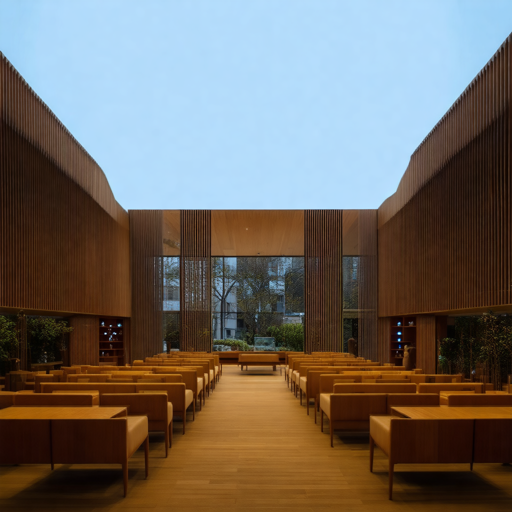

In [42]:
inputs = processor(text=texts, images=image_ours[-1], return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs) 

target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# draw boxes with labels == 0
copy = image_ours[-1].copy()
draw = ImageDraw.Draw(copy)
for box, score, label in zip(boxes, scores, labels):
    if label == 0:
        box = [round(i, 2) for i in box.tolist()]
        draw.rectangle(box, outline="blue", width=3)
        draw.text((box[0], box[1]), f"{score.item():.2f}", fill="blue")
copy.resize((512, 512))

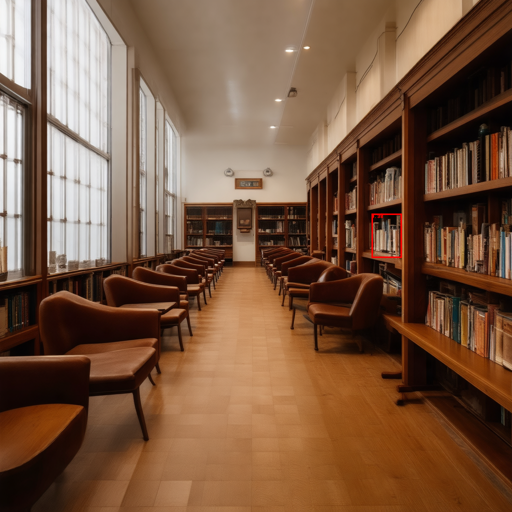

In [35]:
inputs = processor(text=texts, images=image_vanilla[-1], return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs) 

target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
max_score = torch.max(scores[labels == 0])
# draw boxes with labels == 0
copy = image_vanilla[-1].copy()
draw = ImageDraw.Draw(copy)
for box, score, label in zip(boxes, scores, labels):
    if label == 0 and score == max_score:
        box = [round(i, 2) for i in box.tolist()]
        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1]), f"{score.item():.2f}", fill="red")
copy.resize((512, 512))

In [6]:

# frames = []
# for i in range(len(image_ours)):
#     frame = np.concatenate(
#         [np.array(image_ours[i]), np.array(image_vanilla[i])], axis=1
#     )
#     frames.append(Image.fromarray(frame))

# # save as a video
# import imageio
# imageio.mimwrite(
#     "sd3_ours_vs_vanilla.mp4",
#     frames,
#     fps=2,
# )
